In [1]:
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.cm as cm
import gsw

In [2]:
# We shall use the most recent model years, which at the moment is 0996 to 1000
rootdir = '/archive/oar.gfdl.cmip6/ESM4/DECK/ESM4_piControl_D/gfdl.ncrc4-intel16-prod-openmp/pp/'
datadir = 'ocean_annual_z_1x1deg/ts/annual/5yr/'
filename_age = 'ocean_annual_z_1x1deg.0996-1000.agessc.nc'
filename_temp = 'ocean_annual_z_1x1deg.0996-1000.thetao.nc'
filename_vol = 'ocean_annual_z_1x1deg.0996-1000.volcello.nc'
filename_so = 'ocean_annual_z_1x1deg.0996-1000.so.nc'

In [3]:
age = xr.open_dataset(rootdir + datadir + filename_age)
temp = xr.open_dataset(rootdir + datadir + filename_temp)
vol = xr.open_dataset(rootdir + datadir + filename_vol)
so = xr.open_dataset(rootdir + datadir + filename_so)

/nbhome/Tyrone.Zhang/miniconda/envs/basic/lib/python3.7/site-packages/xarray/coding/times.py:419: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  self.use_cftime)


In [4]:
potden = gsw.density.sigma2(so.so, temp.thetao)
lat = so.lat 
lon = so.lon
time = so.time
z_l = so.z_l

In [5]:
pot_den = xr.DataArray(potden, coords = [time, z_l, lat, lon ], dims = ['time', 'z_l', 'lat', 'lon'])
pot_den.name = 'Potential Density'

In [6]:
ds = xr.merge([temp, age, vol, so])
df = xr.merge([ds, pot_den])
print(df)

<xarray.Dataset>
Dimensions:            (bnds: 2, lat: 180, lon: 360, time: 5, z_i: 36, z_l: 35)
Coordinates:
  * lat                (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
  * lon                (lon) float64 0.5 1.5 2.5 3.5 ... 356.5 357.5 358.5 359.5
  * time               (time) object 0996-07-02 12:00:00 ... 1000-07-02 12:00:00
  * z_i                (z_i) float64 0.0 5.0 15.0 ... 5.75e+03 6.25e+03 6.75e+03
  * z_l                (z_l) float64 2.5 10.0 20.0 ... 5.5e+03 6e+03 6.5e+03
Dimensions without coordinates: bnds
Data variables:
    average_DT         (time) timedelta64[ns] 365 days 365 days ... 365 days
    average_T1         (time) object 0995-04-28 00:00:00 ... 0999-04-27 00:00:00
    average_T2         (time) object 0996-04-27 00:00:00 ... 1000-04-26 00:00:00
    lat_bnds           (lat, bnds) float64 -90.0 -89.0 -89.0 ... 89.0 89.0 90.0
    lon_bnds           (lon, bnds) float64 0.0 1.0 1.0 2.0 ... 359.0 359.0 360.0
    thetao             (time, z_l, la

/nbhome/Tyrone.Zhang/miniconda/envs/basic/lib/python3.7/site-packages/numpy/core/numeric.py:538: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)
/nbhome/Tyrone.Zhang/miniconda/envs/basic/lib/python3.7/site-packages/numpy/core/numeric.py:538: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)
/nbhome/Tyrone.Zhang/miniconda/envs/basic/lib/python3.7/site-packages/numpy/core/numeric.py:538: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)
/nbhome/Tyrone.Zhang/miniconda/envs/basic/lib/python3.7/site-packages/num

In [8]:
# Let's define certain functions namely, weighted mean and weighted standard deviation
def weightedstd(ds,variable,weights):
    # variable and weights are strings
    M = ds[variable].size
    variable_times_weights = ds[variable]*ds[weights]
    weightedmean = variable_times_weights.sum()/ds[weights].sum()
    numerator = ds[weights]*(ds[variable]-weightedmean)**2
    numerator = numerator.sum()
    denominator = ((M-1)/M)*ds[weights].sum()
    weightedstd = numerator/denominator
    return weightedstd
def weightedmean(ds,variable,weights):
    # variable and weights are strings
    variable_times_weights = ds[variable]*ds[weights]
    weightedmean = variable_times_weights.sum()/ds[weights].sum()
    return weightedmean

In [9]:
# This is the calculation for density binning
potden_bins = np.arange(30, 38, 0.25)
potden_bins_labels = np.arange(30.125, 37.875, .25)
df_in_potden = df.isel(time=0).groupby_bins('Potential Density',potden_bins,labels=potden_bins_labels)
age_mean_potden = df_in_potden.apply(weightedmean, variable = 'agessc', weights = 'volcello')
age_wstd_potden = df_in_potden.apply(weightedstd, variable = 'agessc', weights = 'volcello')
#Note that we are calculating the square of the standard deviation, so we need to take the square root to get the 
# standard deviation. 
age_wstd_potden = age_wstd_potden**(0.5)
print(age_mean_potden)
print(age_wstd_potden)

<xarray.DataArray (Potential Density_bins: 31)>
array([2.092953e+00, 1.409390e+01, 1.173526e+00, 1.372118e+00, 1.691239e+00,
       2.393119e+00, 3.542305e+00, 4.589247e+00, 4.863744e+00, 5.831168e+00,
       6.398457e+00, 8.487252e+00, 8.368228e+00, 8.407021e+00, 1.150460e+01,
       1.514023e+01, 2.127892e+01, 2.461647e+01, 4.957736e+01, 5.290467e+01,
       6.787214e+01, 1.066418e+02, 2.102226e+02, 3.214983e+02, 4.869750e+02,
       6.690471e+02, 7.322061e+02, 7.603666e+02, 2.568473e+02, 2.673550e+02,
       4.545275e-01], dtype=float32)
Coordinates:
  * Potential Density_bins  (Potential Density_bins) float64 30.12 ... 37.62
    time                    object 0996-07-02 12:00:00
<xarray.DataArray (Potential Density_bins: 31)>
array([5.380363e+00, 1.675634e+01, 2.516933e+00, 2.856973e+00, 3.370023e+00,
       4.641083e+00, 6.935404e+00, 7.864470e+00, 7.972759e+00, 9.120444e+00,
       1.109839e+01, 1.496844e+01, 1.331314e+01, 1.476092e+01, 1.790912e+01,
       2.239169e+01, 2.723039

In [10]:
# This is the calculation for the depth binning
z_small = z_l[:34]
df_in_depth = df.isel(time=0).groupby_bins('z_l',z_l,labels=z_small)
agev_mean_depth = df_in_depth.apply(weightedmean, variable ='agessc', weights = 'volcello')
agev_wstd_depth = df_in_depth.apply(weightedstd, variable= 'agessc', weights = 'volcello')
# Again we will take the square root for weighted standard deviation
agev_wstd_depth = agev_wstd_depth**(0.5)
print(agev_mean_depth)
print(agev_wstd_depth)


<xarray.DataArray (z_l_bins: 34)>
array([7.184072e-01, 1.372282e+00, 2.561968e+00, 5.185956e+00, 1.035904e+01,
       1.810767e+01, 2.759988e+01, 4.129010e+01, 6.093365e+01, 8.113711e+01,
       1.053888e+02, 1.412514e+02, 1.931937e+02, 2.594665e+02, 3.350917e+02,
       4.155447e+02, 4.930567e+02, 5.585744e+02, 6.105391e+02, 6.504372e+02,
       6.795936e+02, 6.992916e+02, 7.165724e+02, 7.316676e+02, 7.439197e+02,
       7.628685e+02, 7.878213e+02, 7.917745e+02, 7.639512e+02, 7.184537e+02,
       7.045392e+02, 7.586730e+02, 7.933185e+02, 7.760710e+02], dtype=float32)
Coordinates:
  * z_l_bins  (z_l_bins) float64 2.5 10.0 20.0 32.5 ... 5e+03 5.5e+03 6e+03
    time      object 0996-07-02 12:00:00
<xarray.DataArray (z_l_bins: 34)>
array([  2.703582,   4.998026,   8.099272,  12.939166,  20.881151,  33.626855,
        47.881606,  65.141495,  86.287586, 102.217315, 115.57764 , 132.58668 ,
       155.982354, 182.559492, 210.108994, 238.816679, 267.140039, 293.234273,
       314.01433 , 329.7

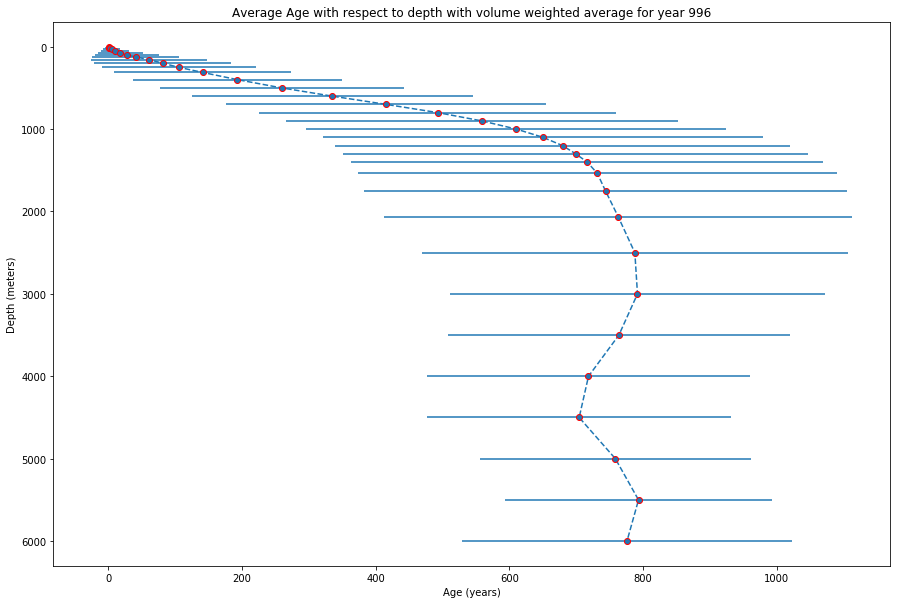

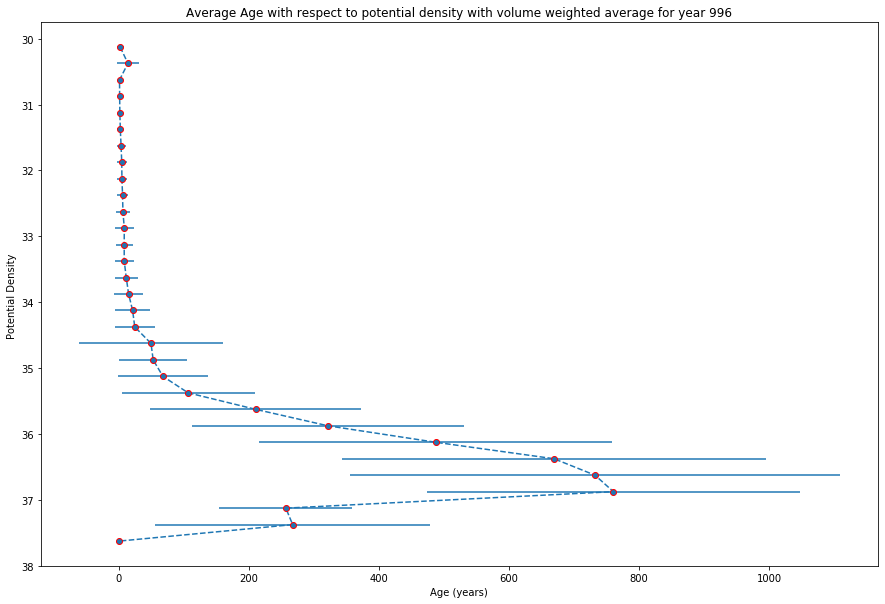

In [12]:
# Here are the graphs for both of them in a side by side comparison
# Plot for depth and age
plt.figure(figsize = (15,10))
plt.errorbar(agev_mean_depth, z_small, xerr = agev_wstd_depth, marker = 'o', linestyle = '--', markeredgecolor = 'r')
plt.title('Average Age with respect to depth with volume weighted average for year 996')
plt.gca().invert_yaxis() # Flips y axis, since depth of 0 is the ocean surface, but for comparison purposes we will not do that
plt.ylabel('Depth (meters)')
plt.xlabel('Age (years)')
plt.show()
# Here is the plot for density and age
plt.figure(figsize = (15,10))
plt.errorbar(age_mean_potden, potden_bins_labels, xerr = age_wstd_potden, marker = 'o', linestyle = '--', markeredgecolor = 'r')
plt.title('Average Age with respect to potential density with volume weighted average for year 996')
plt.gca().invert_yaxis()
plt.ylabel('Potential Density ')
plt.xlabel('Age (years)')
plt.show()